In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    matthews_corrcoef,
    classification_report,
    confusion_matrix
)

In [4]:
CSV_PATH = "Data/merged_dataset.csv"

In [6]:
# load merged dataset
df = pd.read_csv("Data/merged_dataset.csv", parse_dates=["Week"])
df = df.sort_values("Week").reset_index(drop=True)

In [7]:
# Compute weekly return and target
df["Return"] = df["Close"].pct_change()
df["Target"] = np.where(df["Return"] > 0.01, 1,
                np.where(df["Return"] < -0.01, -1, 0))
df = df.dropna(subset=["Return"])

In [8]:
# Parse date and sort
date_col = "Week" if "Week" in df.columns else None
if date_col is None:
    raise ValueError("Expected a 'Week' column in the CSV for time ordering.")
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df = df.sort_values(date_col).reset_index(drop=True)

In [9]:
# Drop any leading NaNs from Return-based construction (safe)
df = df.dropna(subset=["Target"]).reset_index(drop=True)

In [10]:
# Show basic info
print("Rows:", len(df))
print("Date range:", df[date_col].min().date(), "→", df[date_col].max().date())
print("Class counts:", df["Target"].value_counts().to_dict())


Rows: 239
Date range: 2007-02-04 → 2013-12-01
Class counts: {1: 94, 0: 75, -1: 70}


In [11]:
# Time split: choose one
TEST_SIZE_RATIO = 0.20          # last 20% as test (default)
TEST_START_DATE = None           # e.g., "2012-01-01" to test from this week onward

# Labels order for plots and reports (keep consistent with your RF)
LABEL_ORDER = [-1, 0, 1]

# Output files (saved in working dir)
OUT_PREFIX = "random_walk_baseline"
SAVE_ARTIFACTS = True  # set False if you don't want CSV/PNGs saved

In [12]:
# -----------------------------
# Train/Test split (time-based)
# -----------------------------
if TEST_START_DATE is not None:
    cutoff = pd.to_datetime(TEST_START_DATE)
    split_idx = int((df[date_col] < cutoff).sum())
else:
    split_idx = int(len(df) * (1 - TEST_SIZE_RATIO))

train_idx = np.arange(0, split_idx)
test_idx  = np.arange(split_idx, len(df))

In [13]:
print(f"Split index: {split_idx}  |  Train: {len(train_idx)}  Test: {len(test_idx)}")

Split index: 191  |  Train: 191  Test: 48


In [14]:
# -----------------------------
# Random-walk (persistence) prediction
# ŷ_t = Target_{t-1}, evaluated on the test window
# -----------------------------
df["Target_lag1"] = df["Target"].shift(1)

y_true_full = df.loc[test_idx, "Target"]
y_pred_full = df.loc[test_idx, "Target_lag1"]

In [15]:
# First test row might not have a previous week → drop NaN
mask = ~y_pred_full.isna()
y_true = y_true_full[mask].astype(int)
y_pred = y_pred_full[mask].astype(int)


In [16]:
print("Aligned test size:", len(y_true))

Aligned test size: 48


In [17]:
# -----------------------------
# Metrics (multi-class)
# -----------------------------
def evaluate_and_report(y_true, y_pred, labels, title_prefix=""):
    acc = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    report = classification_report(
        y_true, y_pred, labels=labels, zero_division=0, output_dict=True
    )
    report_df = pd.DataFrame(report).transpose()
    summary_df = pd.DataFrame([{"Accuracy": acc, "Matthews CC": mcc}])

    print(f"\n=== {title_prefix} Summary ===")
    print(summary_df.round(4))
    print(f"\n=== {title_prefix} Classification Report ===")
    print(report_df.round(4))

    return summary_df, report_df

In [19]:
summary_df, report_df = evaluate_and_report(y_true, y_pred, LABEL_ORDER, "Random-Walk (3-class)")


=== Random-Walk (3-class) Summary ===
   Accuracy  Matthews CC
0    0.3958       0.0633

=== Random-Walk (3-class) Classification Report ===
              precision  recall  f1-score  support
-1               0.2727  0.2727    0.2727  11.0000
0                0.5238  0.5238    0.5238  21.0000
1                0.3125  0.3125    0.3125  16.0000
accuracy         0.3958  0.3958    0.3958   0.3958
macro avg        0.3697  0.3697    0.3697  48.0000
weighted avg     0.3958  0.3958    0.3958  48.0000


In [20]:
# -----------------------------
# Confusion matrices
# -----------------------------
def plot_cm(cm, labels, title, fname=None):
    fig, ax = plt.subplots(figsize=(5.5, 4.5))
    im = ax.imshow(cm, aspect='auto')
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            txt = f"{cm[i, j]:.2f}" if cm.dtype.kind == "f" else f"{cm[i, j]:.0f}"
            ax.text(j, i, txt, ha="center", va="center")
    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    if SAVE_ARTIFACTS and fname:
        plt.savefig(fname, dpi=160, bbox_inches="tight")
    plt.show()

In [21]:
cm_counts = confusion_matrix(y_true, y_pred, labels=LABEL_ORDER)
row_sums = cm_counts.sum(axis=1, keepdims=True)
cm_row_norm = np.divide(cm_counts, row_sums, out=np.zeros_like(cm_counts, dtype=float), where=row_sums!=0)

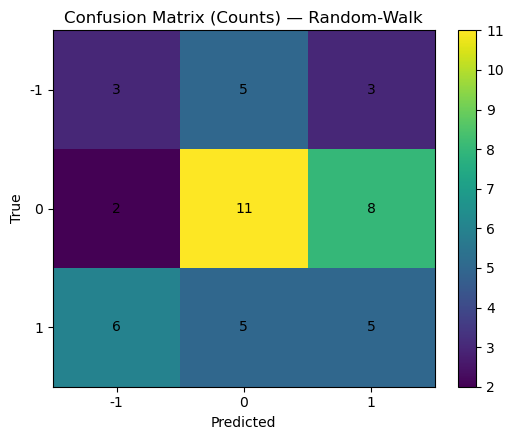

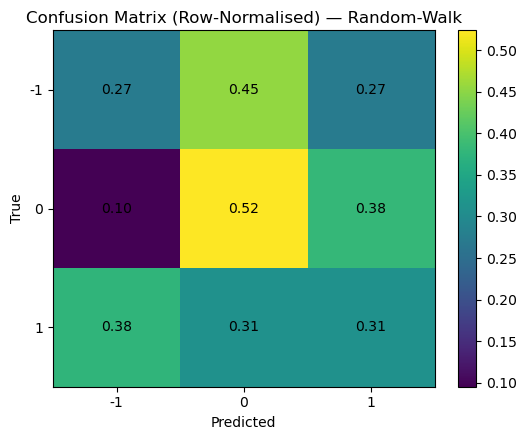

In [22]:
plot_cm(cm_counts, LABEL_ORDER, "Confusion Matrix (Counts) — Random-Walk",
        fname=f"{OUT_PREFIX}_cm_counts.png" if SAVE_ARTIFACTS else None)
plot_cm(cm_row_norm, LABEL_ORDER, "Confusion Matrix (Row-Normalised) — Random-Walk",
        fname=f"{OUT_PREFIX}_cm_row_norm.png" if SAVE_ARTIFACTS else None)

In [23]:
# -----------------------------
# Save artifacts
# -----------------------------
if SAVE_ARTIFACTS:
    summary_df.to_csv(f"{OUT_PREFIX}_summary.csv", index=False)
    report_df.to_csv(f"{OUT_PREFIX}_classification_report.csv")
    pd.DataFrame(cm_counts, index=[f"T{c}" for c in LABEL_ORDER], columns=[f"P{c}" for c in LABEL_ORDER]) \
        .to_csv(f"{OUT_PREFIX}_cm_counts.csv")
    pd.DataFrame(cm_row_norm, index=[f"T{c}" for c in LABEL_ORDER], columns=[f"P{c}" for c in LABEL_ORDER]) \
        .to_csv(f"{OUT_PREFIX}_cm_row_norm.csv")
    print("\nSaved CSVs and PNGs with prefix:", OUT_PREFIX)


Saved CSVs and PNGs with prefix: random_walk_baseline
